In [ ]:
from nbdev import *

In [ ]:
#default_exp dcae

In [ ]:
#hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DCAE: Deep Convolutional Autoencoder

> This notebook tries to apply the ideas of the paper [TimeCluster](https://link.springer.com/article/10.1007/s00371-019-01673-y),
with regard to the application of DCAEs for compressing multivariate time series data.

In [ ]:
#export
from fastcore import test
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPool1D, Reshape, UpSampling1D, InputLayer

In [ ]:
#hide
from timecluster_extension.load import *
from timecluster_extension.utils import *
from timecluster_extension.dr import *
from timecluster_extension.visualization import *
from tensorflow.keras.optimizers import Adam
import wandb
from wandb.keras import WandbCallback
from yaml import load, FullLoader
from fastcore.utils import Path
from datetime import datetime
import pickle

For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

Before running this notebook, make sure you have the `$WANDB_API_KEY` environment varibale defined with your API_KEY (run in a terminal `echo $WANDB_API_KEY` to see it). If not, run in a terminal `wandb login [API_KEY]`. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account.

In [ ]:
#hide
run_dcae = wandb.init(entity = "pacmel",
                      project="timecluster-extension",
                      job_type='train_DCAE',
                      allow_val_change=True,
                      resume=False)
config = wandb.config  # Object for storing hyperparameters

wandb: wandb version 0.10.18 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Loading the datasets

To load the dataset we will download a specific dataset artifact from the collection of artifacts
stored in the weights and biases (wandb) project associated to this experiment.

In [ ]:
artifact_train_name_version = 'JNK:v31'
artifact_validation_name_version = 'JNK:v32'

In [ ]:
ds_train_artifact = run_dcae.use_artifact(artifact_train_name_version)
ds_validation_artifact = run_dcae.use_artifact(artifact_validation_name_version)

In [ ]:
# parameters (uncomment to override the yaml file)
config.update(
    {
          'ds_train_artifact_type': ds_train_artifact.type,
          'ds_train_artifact_name': ds_train_artifact.name,
          'ds_train_artifact_digest': ds_train_artifact.digest,
          'ds_validation_artifact_type': ds_validation_artifact.type,
          'ds_validation_artifact_name': ds_validation_artifact.name,
          'ds_validation_artifact_digest': ds_validation_artifact.digest
    }, 
    allow_val_change=True)
print(ds_train_artifact.type, ds_train_artifact.name, ds_train_artifact.digest)
print(ds_validation_artifact.type, ds_validation_artifact.name, ds_validation_artifact.digest)

dataset JNK:v31 7253d647bfde564454c51587470af7a3
dataset JNK:v32 00a36705dc0ceeaa3e5c0681729afbb2


The artifact must have been logged from a `TSArtifact` object. IF that's true, the metadata of the downloaded artifact will contain all the necessary information to recover the dataframe containing the time series.

In [ ]:
ds_train_artifact.metadata

{'TS': {'ed': '2019-06-15 23:59:59',
  'sd': '2019-06-01 00:00:00',
  'freq': '<5 * Seconds>',
  'hash': '3771369201427785544',
  'vars': ['RCD_AverageThree-phaseCurrent',
   'LCD_AverageThree-phaseCurrent',
   'LP_AverageThree-phaseCurrent',
   'LHD_LeftHaulageDrive(tractor)Temperature(gearbox)',
   'RHD_RightHaulageDrive(tractor)Temperature(gearbox)',
   'LA_LeftArmTemperature',
   'RA_RightArmTemperature',
   'SM_DailyRouteOfTheShearer',
   'SM_TotalRoute',
   'LHD_EngineCurrent',
   'RHD_EngineCurrent',
   'RCD_BearingTemperature',
   'SM_ShearerSpeed',
   'SM_ShearerLocation'],
  'n_vars': 14,
  'created': 'from-df',
  'n_samples': 259200,
  'normalization': {'stds': {'SM_TotalRoute': 18.041910697747443,
    'SM_ShearerSpeed': 3.154401611746743,
    'LHD_EngineCurrent': 22.96903715909201,
    'RHD_EngineCurrent': 22.322453739143615,
    'SM_ShearerLocation': 84.53613420968614,
    'LA_LeftArmTemperature': 12.062064306810887,
    'RA_RightArmTemperature': 14.594512578518268,
    'R

In [ ]:
ds_validation_artifact.metadata

{'TS': {'ed': '2019-06-20 23:59:59',
  'sd': '2019-06-16 00:00:00',
  'freq': '<5 * Seconds>',
  'hash': '7356689440268017107',
  'vars': ['RCD_AverageThree-phaseCurrent',
   'LCD_AverageThree-phaseCurrent',
   'LP_AverageThree-phaseCurrent',
   'LHD_LeftHaulageDrive(tractor)Temperature(gearbox)',
   'RHD_RightHaulageDrive(tractor)Temperature(gearbox)',
   'LA_LeftArmTemperature',
   'RA_RightArmTemperature',
   'SM_DailyRouteOfTheShearer',
   'SM_TotalRoute',
   'LHD_EngineCurrent',
   'RHD_EngineCurrent',
   'RCD_BearingTemperature',
   'SM_ShearerSpeed',
   'SM_ShearerLocation'],
  'n_vars': 14,
  'created': 'from-df',
  'n_samples': 86400,
  'has_missing_values': 'False',
  'handle_missing_values_technique': 'linear_interpolation'}}

The training data that will be used in the rest of the notebook will be stored in the dataframe `df_train`

In [ ]:
df_train = ds_train_artifact.to_df()
df_train

,RCD_AverageThree-phaseCurrent,LCD_AverageThree-phaseCurrent,LP_AverageThree-phaseCurrent,LHD_LeftHaulageDrive(tractor)Temperature(gearbox),RHD_RightHaulageDrive(tractor)Temperature(gearbox),LA_LeftArmTemperature,RA_RightArmTemperature,SM_DailyRouteOfTheShearer,SM_TotalRoute,LHD_EngineCurrent,RHD_EngineCurrent,RCD_BearingTemperature,SM_ShearerSpeed,SM_ShearerLocation
TIMESTAMP,,,,,,,,,,,,,,
2019-06-01 00:00:00,-1.000188,-0.997982,-0.780818,-2.340634,-0.325954,-3.368229,-3.116624,-1.119258,-7.557030,-0.620246,-0.619448,-3.611127,-0.424728,0.804538
2019-06-01 00:00:05,-1.000188,-0.997982,-0.780818,-2.340634,-0.325954,-3.368229,-3.116624,-1.119258,-7.557030,-0.620246,-0.619448,-3.611127,-0.424728,0.804538
2019-06-01 00:00:10,-1.000188,-0.997982,-0.780818,-2.340634,-0.325954,-3.368229,-3.116624,-1.119258,-7.557030,-0.620246,-0.619448,-3.611127,-0.424728,0.804538
2019-06-01 00:00:15,-1.000188,-0.997982,-0.780818,-2.340634,-0.325954,-3.368229,-3.116624,-1.119258,-7.557030,-0.620246,-0.619448,-3.611127,-0.424728,0.804538
2019-06-01 00:00:20,-1.000188,-0.997982,-0.780818,-2.340634,-0.325954,-3.368229,-3.116624,-1.119258,-7.557030,-0.620246,-0.619448,-3.611127,-0.424728,0.804538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-15 23:59:35,-0.672804,-0.713150,0.715432,1.254256,-0.325954,0.859903,0.377840,1.159216,1.383265,-0.620246,-0.619448,0.287103,-0.424728,-1.017168
2019-06-15 23:59:40,-0.672804,-0.713150,0.715432,1.254256,-0.325954,0.859903,0.377840,1.159216,1.383265,-0.620246,-0.619448,0.287103,-0.424728,-1.017168
2019-06-15 23:59:45,-0.672804,-0.713150,0.715432,1.254256,-0.325954,0.859903,0.377840,1.159216,1.383265,-0.620246,-0.619448,0.287103,-0.424728,-1.017168


Validation data is not normalized. We need to normalize them with the means/stds of the training data

In [ ]:
df_val = normalize_artifact(ds_validation_artifact, ds_train_artifact)

Artifacts are compatible.


In [ ]:
df_val

,RCD_AverageThree-phaseCurrent,LCD_AverageThree-phaseCurrent,LP_AverageThree-phaseCurrent,LHD_LeftHaulageDrive(tractor)Temperature(gearbox),RHD_RightHaulageDrive(tractor)Temperature(gearbox),LA_LeftArmTemperature,RA_RightArmTemperature,SM_DailyRouteOfTheShearer,SM_TotalRoute,LHD_EngineCurrent,RHD_EngineCurrent,RCD_BearingTemperature,SM_ShearerSpeed,SM_ShearerLocation
TIMESTAMP,,,,,,,,,,,,,,
2019-06-16 00:00:00,-0.672804,-0.71315,-0.780818,-1.102394,-0.325954,-1.046902,-1.129575,-1.119258,1.383265,-0.620246,-0.619448,-1.502248,-0.424728,-1.017168
2019-06-16 00:00:05,-0.672804,-0.71315,-0.780818,-1.102394,-0.325954,-1.046902,-1.129575,-1.119258,1.383265,-0.620246,-0.619448,-1.502248,-0.424728,-1.017168
2019-06-16 00:00:10,-0.672804,-0.71315,-0.780818,-1.102394,-0.325954,-1.046902,-1.129575,-1.119258,1.383265,-0.620246,-0.619448,-1.502248,-0.424728,-1.017168
2019-06-16 00:00:15,-0.672804,-0.71315,-0.780818,-1.102394,-0.325954,-1.046902,-1.129575,-1.119258,1.383265,-0.620246,-0.619448,-1.502248,-0.424728,-1.017168
2019-06-16 00:00:20,-0.672804,-0.71315,-0.780818,-1.102394,-0.325954,-1.046902,-1.129575,-1.119258,1.383265,-0.620246,-0.619448,-1.502248,-0.424728,-1.017168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-20 23:59:35,-0.672804,-0.71315,-0.780818,-0.423359,-0.325954,0.279571,0.240803,0.022692,2.031755,-0.620246,-0.619448,-0.479762,-0.424728,1.052952
2019-06-20 23:59:40,-0.672804,-0.71315,-0.780818,-0.423359,-0.325954,0.279571,0.240803,0.022692,2.031755,-0.620246,-0.619448,-0.479762,-0.424728,1.052952
2019-06-20 23:59:45,-0.672804,-0.71315,-0.780818,-0.423359,-0.325954,0.279571,0.240803,0.022692,2.031755,-0.620246,-0.619448,-0.479762,-0.424728,1.052952


## Train

### Sliding window features

Define a continuous multivariate time-series data $D$ of dimension $d$ with $n$ time-steps, $D = X_1,X_2,\dots,X_n$ , where each $X_i = \{x_i^1,\dots,x_i^d\}$ . Let $w$ be the window width, $s$ the stride, and $t$ the start time of a sliding window in the data.

Define a new matrix $Z_k$ where each row is a vector of size $w$ of data extracted from the $k^{th}$ dimension.

\begin{aligned}&Z_k(w,s,t)\\&\quad =\begin{bmatrix} x_{t}^k&\quad x_{t+1}^k&\quad \dots&\quad x_{t+w-1}^k \\ x_{t+s}^k&\quad x_{t+s+1}^k&\quad \dots&\quad x_{t+s+w-1}^k \\ \vdots&\quad \vdots&\quad \ddots&\quad \vdots \\ x_{t+(r-1)s}^k&\quad x_{t+(r-1)s+1}^k&\quad \dots&\quad x_{t+(r-1)s+w-1}^k \end{bmatrix} \end{aligned}

where $r$ is the number of desired rows, and $t+(r-1)s+w-1 \le n$


$Z$ is a $w \times s \times t$ matrix. The first step consists in slicing the original multivariate time series into slices of shape ($w \times d$), as shown in this figure from the paper.
<img src="https://i.imgur.com/R9Fx8uO.png" style="width:800px;height:400px"/>

The hyperparameters of this sliding window approach are given values by default here. If the value has been already set previously, that means this notebook is being called from a wandb sweep, and we must use the value that the sweep is bringing.

In [ ]:
config.w = ifnone(config.get('w'), 48)
config.stride = ifnone(config.get('stride'), 1)
config.t = ifnone(config.get('t'), 0)

In [ ]:
# parameters (uncomment to override the yaml file)
config.update({
    'w': config.w,
    'stride': config.stride,
    't': config.t  # TODO: Not supported yet
    }, allow_val_change=True)

In [ ]:
test.equals(config.w % 12, 0)

True

The sliced data must be converted to a numpy array with shape $(n \times w \times d)$, where $n$ is the length of the time series, $w$ is the window size and $d$ is the number of dimensions in the time series. 

In [ ]:
#export utils
def df_slicer(df, w, s=1, padding=False, padding_value=0, return_as='ndarray'):
    "Transform a numeric dataframe `df` into slices (np arrays) of `w` \
    rows and the same number of columns than the original dataframe. The \
    distance between each slice is given by the stride `s`. If `padding` is \
    equals to True, the last slices which have less than `w` points are filled \
    with the value marked in the argument `padding_value`. Otherwise, those \
    slices are removed from the result. TODO: the argument `return_as` is currently \
    not used"
    aux = [df.iloc[x:x+w] for x in range(0, len(df), s)]
    if padding:
        with_padding = [x.append(pd.DataFrame(
            np.full((w - len(x), len(df.columns)), padding_value),
            columns=df.columns.values)) if len(x) < w else x for x in aux]
    else:
        with_padding = [x for x in aux if len(x) == w]
    return np.rollaxis(np.dstack([x.values for x in with_padding]), -1)

In [ ]:
input_data = df_slicer(df_train, w=config.w, s=config.stride)
validation_data = df_slicer(df_val, w=config.w, s=config.stride )
print(f'input_data shape: {input_data.shape}')
print(f'validation_data shape: {validation_data.shape}')

input_data shape: (259153, 48, 14)
validation_data shape: (86353, 48, 14)


Test the number of slices and the size of each slice in the input_data

In [ ]:
expected_nwindows = (int)((len(df_train) - config.w)/config.stride + 1)
expected = [(config.w, len(df_train.columns))]*expected_nwindows
actual = [x.shape for x in input_data]
test.all_equal(expected, actual)

True

Test the number of slices and the size of each slice in the validation_data

In [ ]:
expected_nwindows = (int)((len(df_val) - config.w)/config.stride + 1)
expected = [(config.w, len(df_val.columns))]*expected_nwindows
actual = [x.shape for x in validation_data]
test.all_equal(expected, actual)

True

## Extract important features from the multivariate time series data through Deep Convolutional Autoencoders


Deep Convolutional Auto Encoders (DCAE) is a powerful method for learning high-level and mid-level abstractions from low-level raw data. It has the ability to extract features from complex and large time-series in an unsupervised manner. This is useful to overcome the complexity of multivariate time-series.

Compared to the conventional auto-encoder, DCAE has fewer parameters than the conventional auto-encoder which means less training time. Also, DCAE uses local information to reconstruct the signal while conventional auto-encoders utilize fully connected layers to globally do the reconstruction. DCAE is an unsupervised model for representation learning which maps inputs into a new representation space. It has two main parts which are the encoding part that is used to project the data into a set of feature spaces and the decoding part that reconstructs the original data. The latent space representation is the space where the data lie in the bottleneck layers.

The loss function of the DCAE is defined as the error between the input and the output. DCAE aims to find a code for each input by minimizing the mean squared error (MSE) between its input (original data) and output (reconstructed data). The MSE is used which assists to minimize the loss; thus, the network is forced to learn a low-dimensional representation of the input.

We will implement the DCAE of the paper [TimeCluster](https://link.springer.com/article/10.1007/s00371-019-01673-y), whose architecture is shown in the table below:

![](https://i.imgur.com/3EjuAfQ.png)

Note that, in the paper, the input shape is $60 \times 3$, due to multivariate time series has 3 variables and the window size is 60. Generally, the size of the input/output of the autoencoder will depend on the shape of each slice obtained in the previos step. The number of latent features to be discovered is $60$ in the table above, but we can consider this as a free hyperparameter $\delta$. Also, according to the paper: "*The number of feature maps, size of filter and depth of the model are set based on the reconstruction error on validation set.*". Thus, we must provide flexibility in the creation of the DCAE in terms of these hyperparameters.º

In case you are not using a config file, you can also uncomment the following cell and define the hyperparameters in the fly

In [ ]:
config.lr = ifnone(config.get('lr'),  0.001)
config.n_filters = ifnone(config.get('n_filters'), [64,32,12])
config.filter_sizes = ifnone(config.get('filter_sizes'), [10,5,5])
config.output_filter_size = ifnone(config.get('output_filter_size'), 20)
config.pool_sizes = ifnone(config.get('pool_sizes'), [2, 2, 3])
config.batch_size = ifnone(config.get('batch_size'), 128)
config.epochs = ifnone(config.get('epochs'), 10)

In [ ]:
#hide
config.update({
        'lr': config.lr, # datos previos 0.0009044187712482472, #Poner en el sweep con 0.001
        'n_filters': config.n_filters, # datos previos [32, 16, 12],  # [64,32,12]
        'filter_sizes': config.filter_sizes,  # datos previos [20, 10, 10],  # [10,5,5]
        'output_filter_size': config.output_filter_size,  # datos previos 20,
        'pool_sizes': config.pool_sizes,  # datos previos [2, 2, 3],
        'delta':  config.w,
        'batch_size': config.batch_size,  # datos previos 92, # Batch size to 128
        'epochs': config.epochs,  # datos previos 10 
    }, 
    allow_val_change=True)

In [ ]:
#hide
test.all_equal([len(x) for x in [config.n_filters, config.filter_sizes, config.pool_sizes]], np.repeat(len(config.n_filters), 3))

True

### Create the model

The implementation of the DCAE is done using Keras.

In [ ]:
#export
def createDCAE(w, d, delta, n_filters=[64,32,12], filter_sizes=[10,5,5], pool_sizes=[2,2,3], output_filter_size=10):
    "Create a Deep Convolutional Autoencoder for multivariate time series of `d` dimensions, \
    sliced with a window size of `w`. The parameter `delta` sets the number of latent features that will be \
    contained in the Dense layer of the network. The the number of features \
    maps (filters), the filter size and the pool size can also be adjusted."
    # Test that the parameterization of the model is correct
    # 1. n_filters, filter_sizes and pool_sizes have the same length
    assert test.all_equal([len(x) for x in [n_filters, filter_sizes, pool_sizes]], np.repeat(len(n_filters), 3))
    # 2. Test that the number of filters in the last convLayer is equal to the product of the pool sizes
    assert np.prod(pool_sizes) == n_filters[-1]
    # 3. Test that the product of pool sizes is a divisor of the window size
    assert w % np.prod(pool_sizes).all() == 0
    # Create the model
    model = Sequential()
    model.add(InputLayer(input_shape=(w,d)))
    for (i, x) in enumerate(n_filters):
        model.add(Conv1D(filters=n_filters[i], kernel_size=filter_sizes[i], activation='relu', padding='same'))
        model.add(MaxPool1D(pool_size=pool_sizes[i]))
    aux_shape = model.output_shape[1:]
    model.add(Flatten())
    model.add(Dense(units=np.prod(aux_shape), activation='linear', name='latent_features'))
    model.add(Reshape(target_shape=aux_shape))
    for i, x in reversed(list(enumerate(n_filters))):
        model.add(Conv1D(filters=n_filters[i], kernel_size=filter_sizes[i], activation='relu', padding='same'))
        model.add(UpSampling1D(size=pool_sizes[i]))
    model.add(Conv1D(filters=d, kernel_size=output_filter_size, activation='linear', padding='same'))
    return model

In [ ]:
m = createDCAE(config.w, input_data.shape[-1], config.delta, n_filters=config.n_filters, 
              filter_sizes=config.filter_sizes, pool_sizes=config.pool_sizes,
              output_filter_size=config.output_filter_size)
m.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 48, 64)            9024      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 24, 32)            10272     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 12, 32)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 12, 12)            1932      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 12)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 48)               

In [ ]:
opt = Adam(learning_rate=config.lr)

In [ ]:
m.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_squared_error'])

In [ ]:
history = m.fit(x=input_data, y=input_data, batch_size=config.batch_size, 
      validation_data=(validation_data, validation_data), epochs=config.epochs, verbose=0, 
      callbacks=[WandbCallback(log_weights=True)])




To track the performance of this model fit, go to the project dashboard in Weights & Biases. The link is provided at the beginning of this notebook, after the execution of the function `wandb.init()'' 

## Baseline models

Calculate baseline models taking into account that the best prediction is the average and median value of each of the windows

Baseline predictions:

In [ ]:
y_pred_baseline_med = baseline_model_predictor(validation_data, "median")
y_pred_baseline_mean = baseline_model_predictor(validation_data, "mean")

MSE calculation for each window

In [ ]:
windows_mse_med = get_windows_mse(y_pred_baseline_med, validation_data)
windows_mse_mean = get_windows_mse(y_pred_baseline_mean, validation_data)

Log values to Weight & Biases

In [ ]:
run_dcae.log({
    'mse_baseline_median': windows_mse_med.mean(),
    'mse_baseline_mean': windows_mse_mean.mean(),
})

## Validate the autoencoder

Let's validate the autoencoder quality visually:

#### Get the best and the worst k predictions using the autoencoder

In [ ]:
config.k = ifnone(config.get('k'), 3)

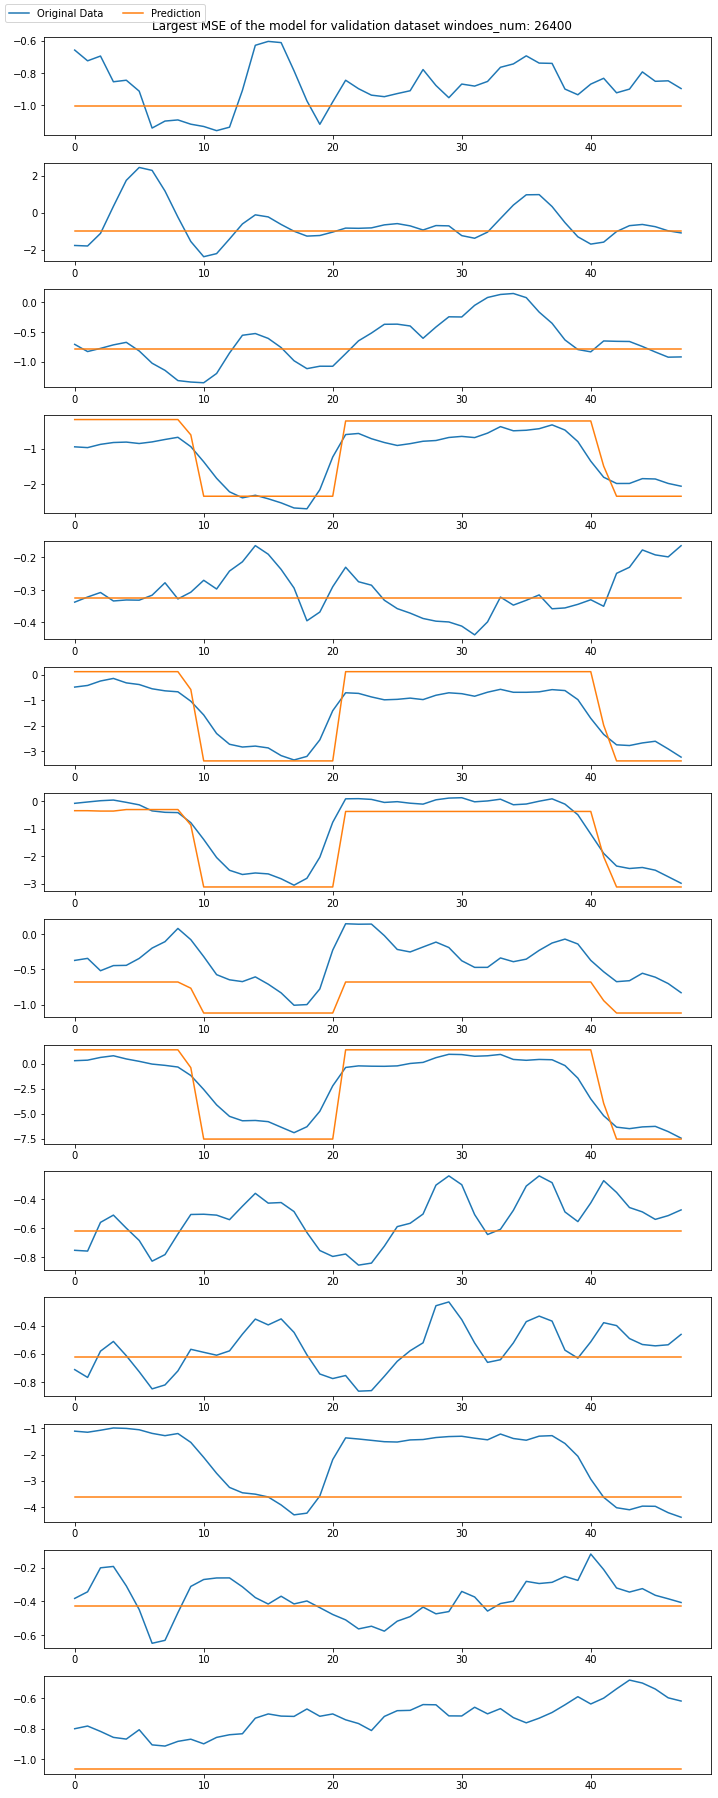

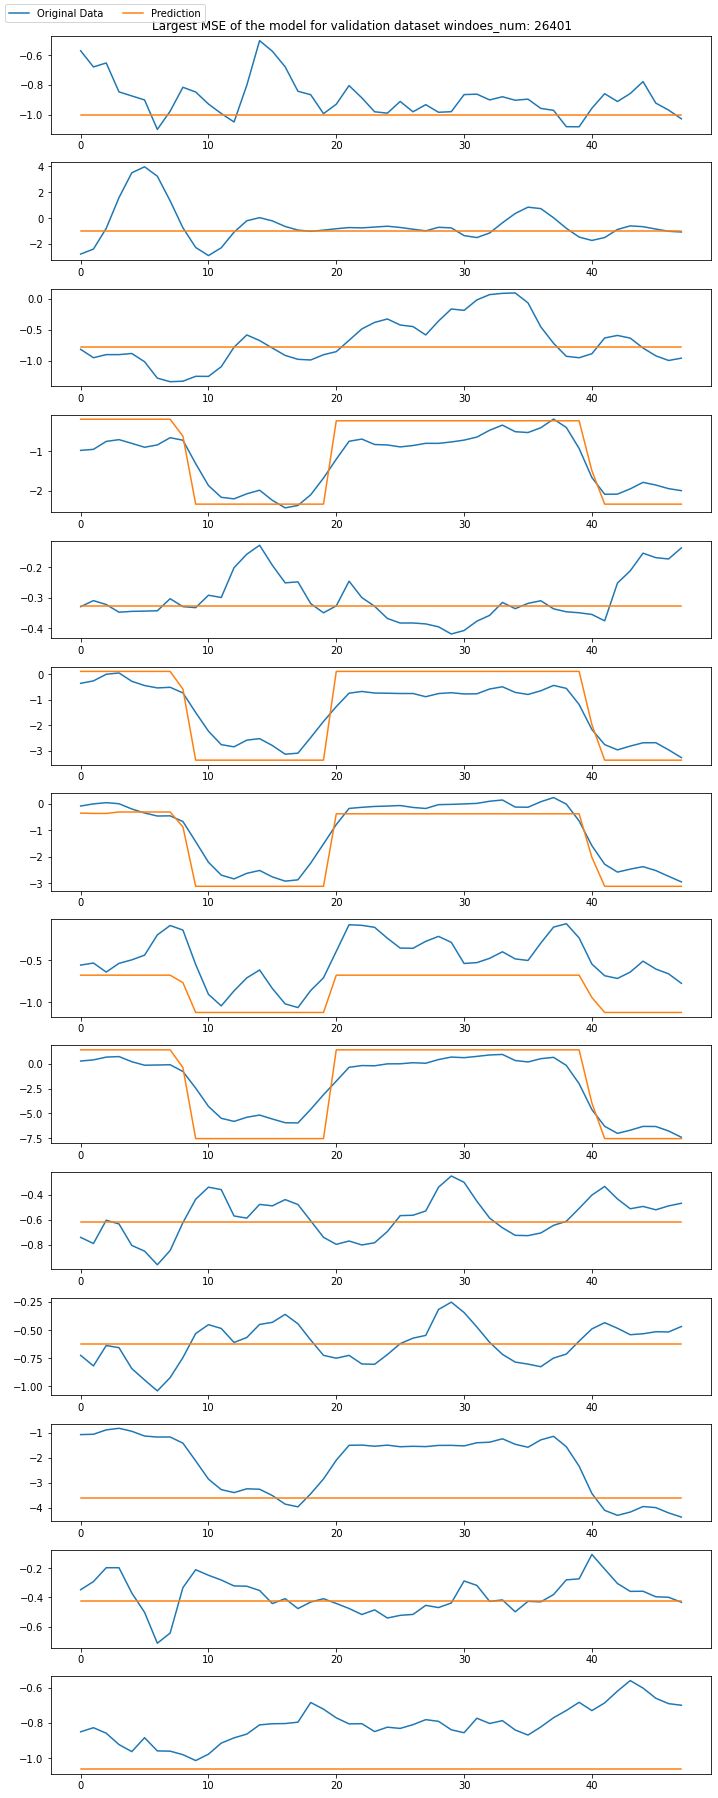

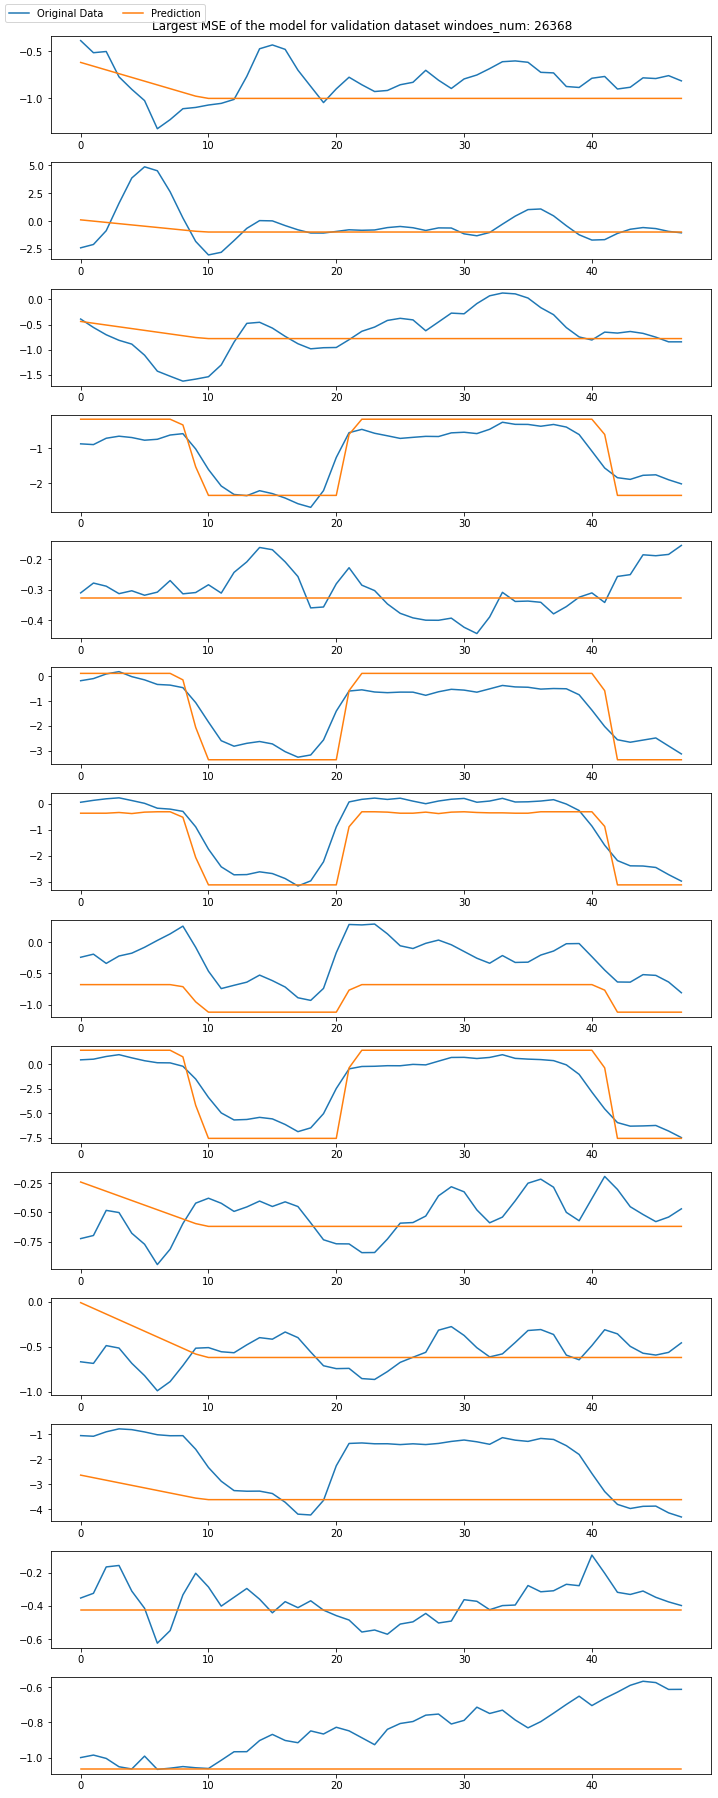

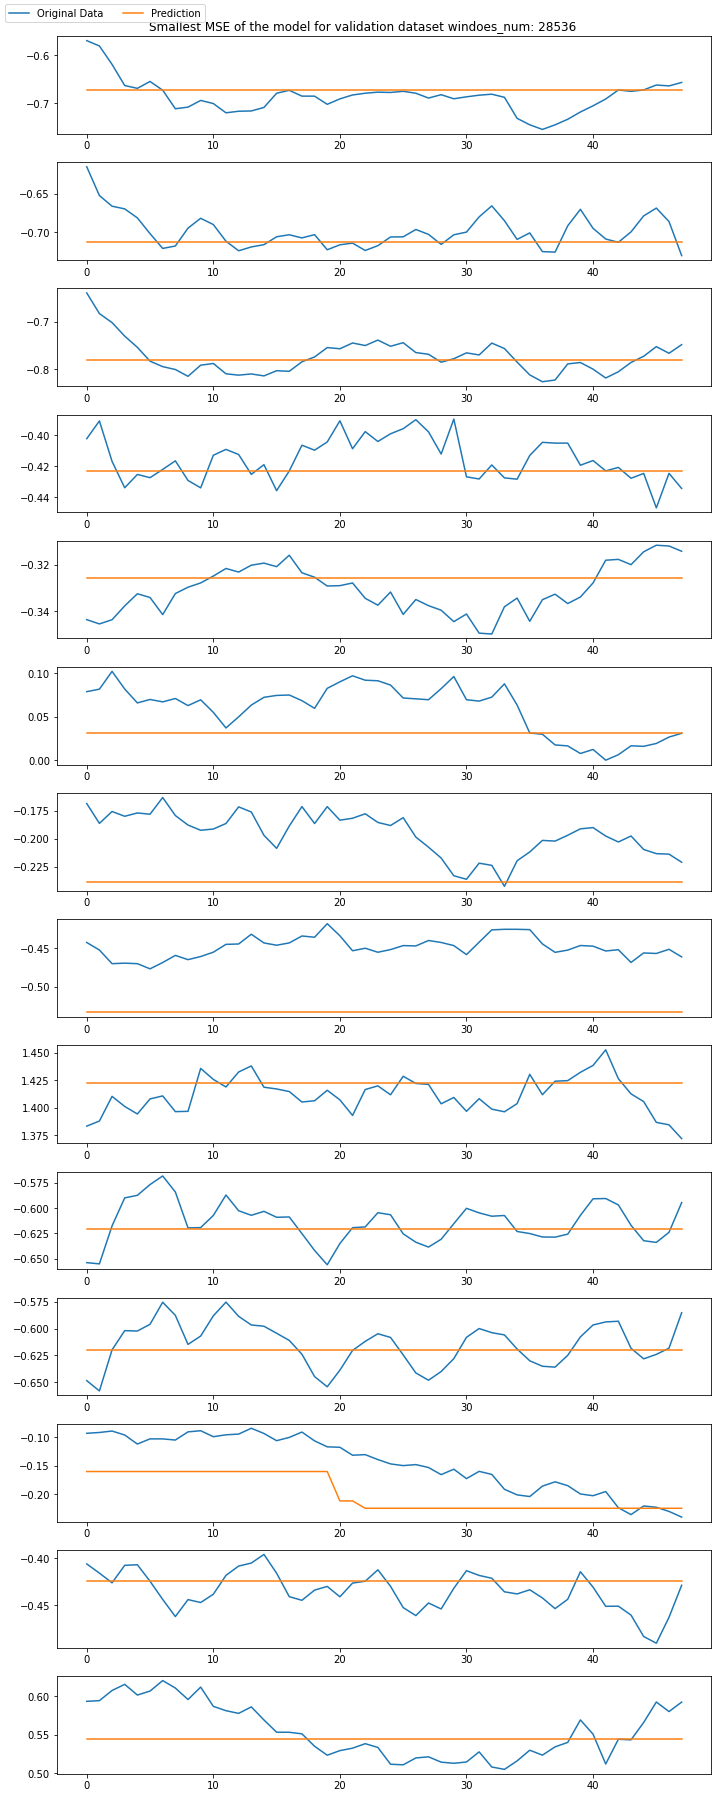

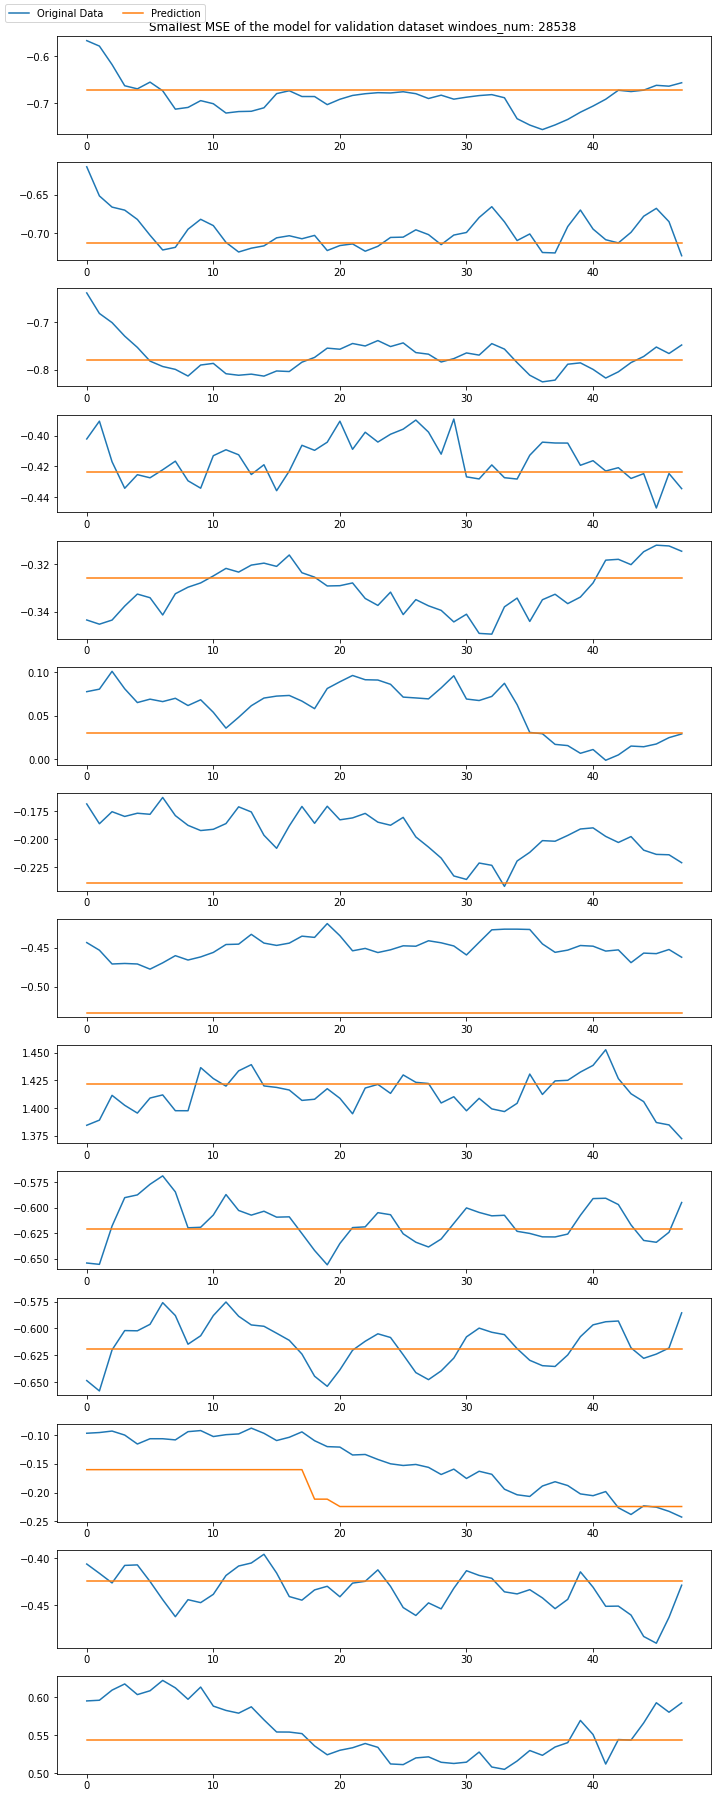

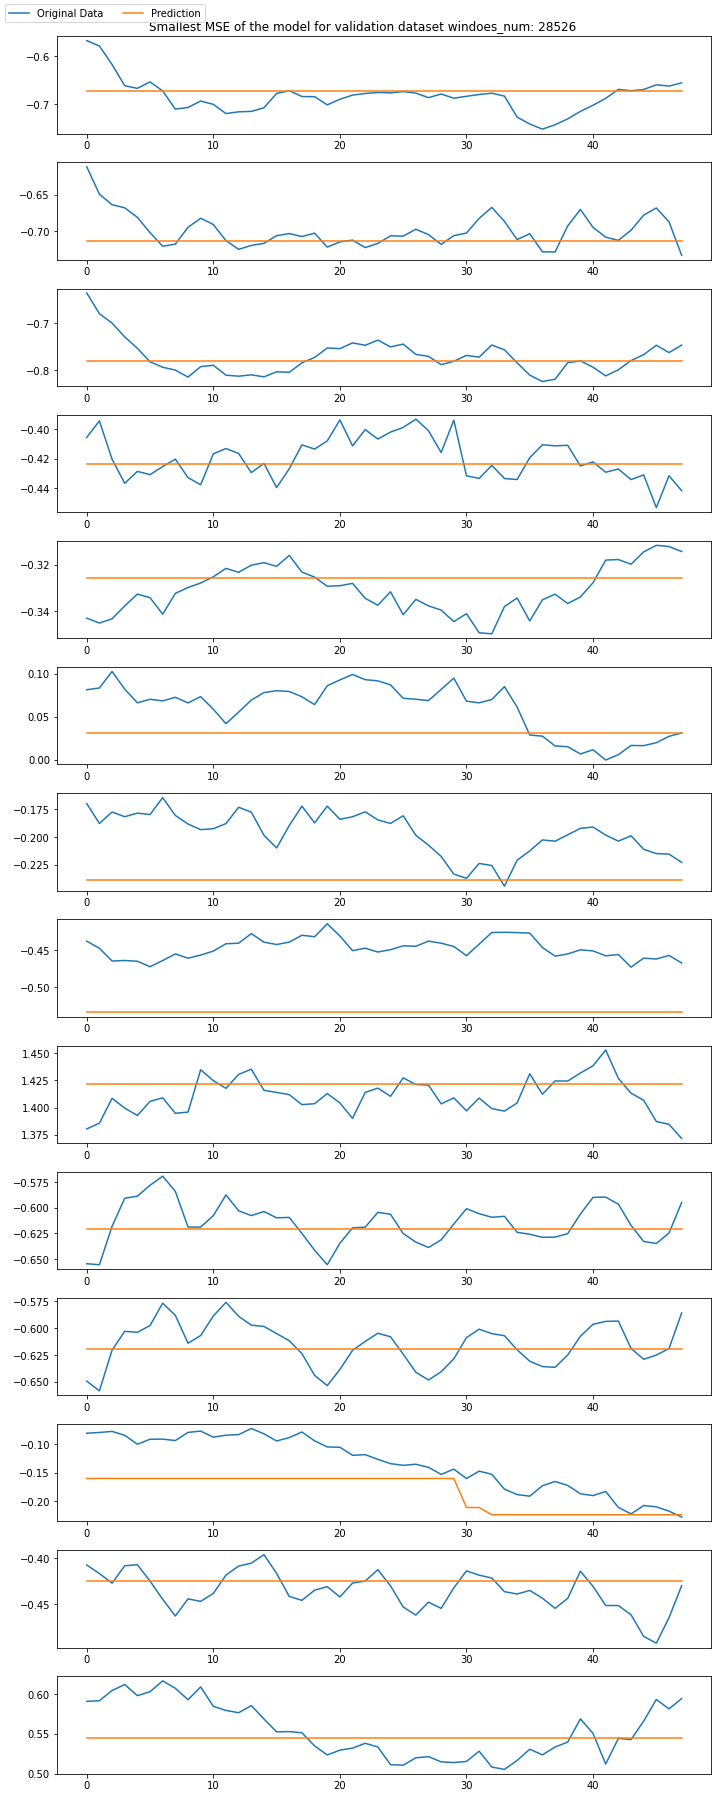

In [ ]:
largest_losses = m.plot_top_losses(validation_data, largest = True, return_fig = True, k=config.k, fig_size = (10,25), title_pos=0.99)
smallest_losses = m.plot_top_losses(validation_data, largest = False, return_fig = True, k=config.k, fig_size = (10,25), title_pos=0.99)

In [ ]:
#hide
for i in range(len(smallest_losses)):
    wandb_figure_name = "Smallest_losses_" + str(i) +  " - w:" + str(config.w) + " - s:" + str(config.stride)
    run_dcae.log({
       wandb_figure_name: [wandb.Image(smallest_losses[i])]
    })

In [ ]:
#hide
for i in range(len(largest_losses)):
    wandb_figure_name = "Largest_losses_" + str(i) + " - w:" + str(config.w) + " - s:" + str(config.stride)
    run_dcae.log({
       wandb_figure_name: [wandb.Image(largest_losses[i])]
    })

In [ ]:
run_dcae.finish()

epoch,9
loss,0.04112
mean_squared_error,0.04112
val_loss,0.04389
val_mean_squared_error,0.04389
_step,16
_runtime,1368
_timestamp,1612953521
best_val_loss,0.04389
best_epoch,9
mse_baseline_median,0.13684


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▂▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁
val_loss,█▄▃▂▂▃▁▂▂▁
val_mean_squared_error,█▄▃▂▂▃▁▂▂▁
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
_runtime,▁▁▂▂▂▂▃▃▃▃▆██████
_timestamp,▁▁▂▂▂▂▃▃▃▃▆██████
mse_baseline_median,▁
mse_baseline_mean,▁
